# Property fields
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/planar/property_fields.ipynb)

This example uses a field for the elastic modulus to create graded properties throughout the model. Then, we use a direct optimization and a neural field to recover the property field from noise observations of the ground truth.

In [1]:
import torch

from torchfem import Planar
from torchfem.materials import IsotropicElasticityPlaneStress
from torchfem.mesh import rect_quad
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# Set double precision
torch.set_default_dtype(torch.float64)

## Forward problem with graded property field

Let's assume we have a graded property field, where the Youngs modulus is prescribed as a function $E : \mathbb{R}^2 \rightarrow \mathbb{R}$ on the domain $\Omega \in [0, 2] \times [0, 1]$. 

The function is given by 
$$
    E(x) = 2 + \sin(\pi x_0) \cos(\pi x_1)
$$

We solve the FEM problem with this exact field to get a synthetic ground truth of the deformation $u_\textrm{ref}$. In addition, we may add some artificial noise to this observation. 

In [2]:
def E(x):
    """Spatially varying material properties"""
    return 2.0 + torch.sin(torch.pi * x[:, 0]) * torch.cos(torch.pi * x[:, 1])

In [3]:
# Create mesh
nodes, elements = rect_quad(21, 11, 2.0, 1.0)

# Compute element centers
ecenters = nodes[elements].mean(dim=1)
X = ecenters[:, 0].reshape(20, 10)
Y = ecenters[:, 1].reshape(20, 10)

# Evaluate material properties at element centers
E_centers = E(ecenters)
nu_centers = 0.3 * torch.ones_like(E_centers)
material = IsotropicElasticityPlaneStress(E=E_centers, nu=nu_centers)

# Create model
sample = Planar(nodes, elements, material, thickness=0.1)

# Boundaries
right = nodes[:, 0] == 2.0
left = nodes[:, 0] == 0.0
top = nodes[:, 1] == 1.0
bottom = nodes[:, 1] == 0.0

# Boundary conditions
sample.forces[right, 0] = 0.01
sample.forces[right & top, 0] *= 0.5
sample.forces[right & bottom, 0] *= 0.5
sample.constraints[left, :] = True

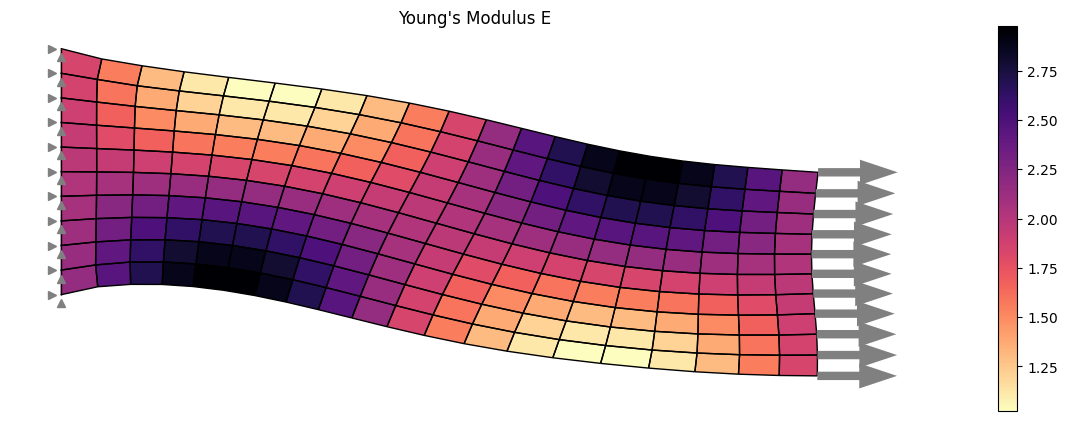

In [4]:
# Solve
u_ref, _, _, _, _ = sample.solve()

# Plot
sample.plot(
    u_ref,
    element_property=E_centers,
    title="Young's Modulus E",
    colorbar=True,
    cmap="magma_r",
    figsize=(15, 5),
)

## Direct solution of the inverse problem

Let's solve the inverse problem now, i.e, we want to estimate the property field leading to the observed deformation field $u_\textrm{ref}$. Hence, we solve 

$$
    \min_E \left( u(E) - u_\textrm{ref} \right)^2
$$

with the computed deformation field $u$ given the modulus field $E$ on elements. We solve this problem directly by taking the modulus of each element as the design variable.  

*Note:* This takes about a minute to solve 4000 iterations.

100%|██████████| 4000/4000 [00:38<00:00, 103.09it/s]


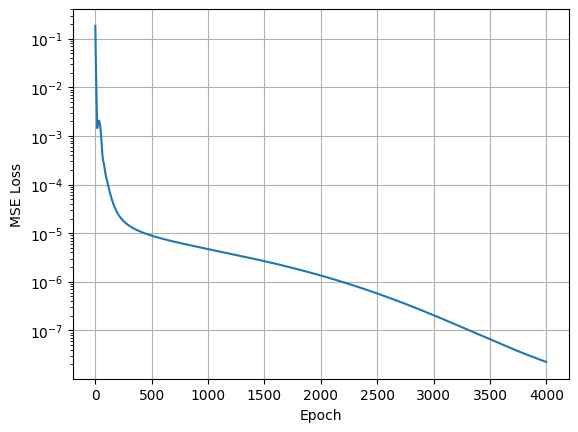

In [5]:
# Set up optimization
E_direct = torch.ones(elements.shape[0], requires_grad=True)
optimizer = torch.optim.Adam([E_direct], lr=0.1)
history = []

for epoch in tqdm(range(4000)):
    # Reset gradients
    optimizer.zero_grad()

    # Update material field
    sample.material = IsotropicElasticityPlaneStress(E=E_direct, nu=nu_centers)

    # Compute MSE loss between predicted and reference displacements
    u, _, _, _, _ = sample.solve()
    loss = torch.mean((u - u_ref) ** 2)

    # Make optimizer step
    loss.backward()
    optimizer.step()

    # Append training loss
    with torch.autograd.no_grad():
        history.append(float(loss.data))

# Plot history
plt.semilogy(history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

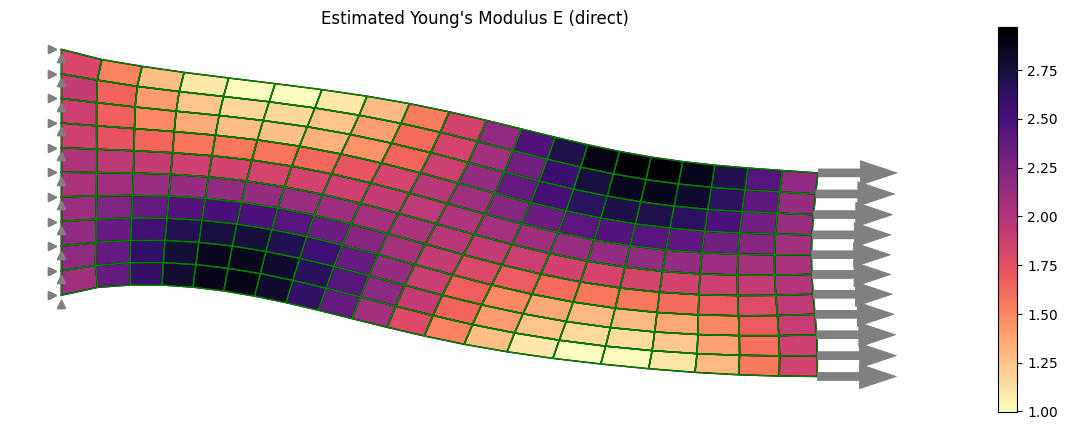

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot optimized
sample.plot(
    u,
    element_property=E_direct,
    title="Estimated Young's Modulus E (direct)",
    colorbar=True,
    cmap="magma_r",
    figsize=(15, 5),
    ax=ax,
)
# Plot reference
sample.plot(u=u_ref, color="green", ax=ax)

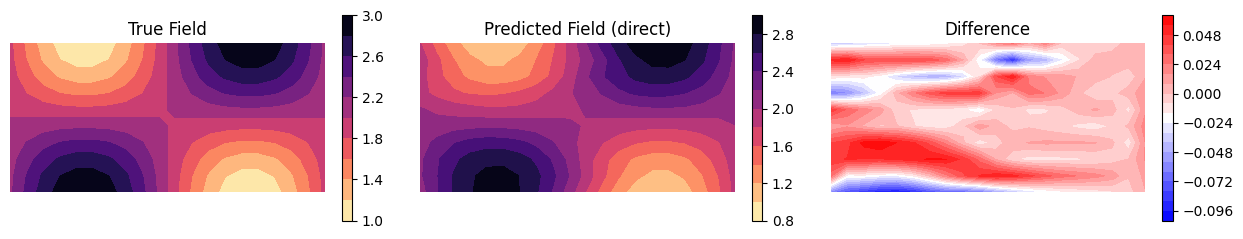

In [7]:
# Evaluate true field on grid
E_true = E(ecenters).reshape(X.shape)

# Predicted field
E_pred = E_direct.detach().reshape(X.shape)

# Evaluate difference
delta = E_pred - E_true

with torch.no_grad():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    c1 = ax[0].contourf(X, Y, E_true, levels=10, cmap="magma_r")
    ax[0].set_title("True Field")
    ax[0].set_aspect("equal")
    ax[0].set_axis_off()
    fig.colorbar(c1, ax=ax[0], fraction=0.03)
    c2 = ax[1].contourf(X, Y, E_pred, levels=10, cmap="magma_r")
    ax[1].set_title("Predicted Field (direct)")
    ax[1].set_aspect("equal")
    ax[1].set_axis_off()
    fig.colorbar(c2, ax=ax[1], fraction=0.03)
    c3 = ax[2].contourf(X, Y, delta, levels=20, cmap="bwr")
    ax[2].set_title("Difference")
    ax[2].set_aspect("equal")
    ax[2].set_axis_off()
    fig.colorbar(c3, ax=ax[2], fraction=0.03)
    plt.show()

In absence of noise, the direct approach converges to the correct discrete solution of the property field with around 1% relative error. Further training and fine tuning would likely reduce the error even more.

## Direct solution of the inverse problem with noise

Let's solve the inverse problem again, but this time with some observation noise of the reference solution.

*Note:* This takes about a minute to solve 4000 iterations.

In [8]:
# Add some artificial noise to the reference solution
noise_level = 0.002
u_ref += noise_level * torch.randn_like(u_ref)

100%|██████████| 4000/4000 [00:41<00:00, 96.02it/s] 


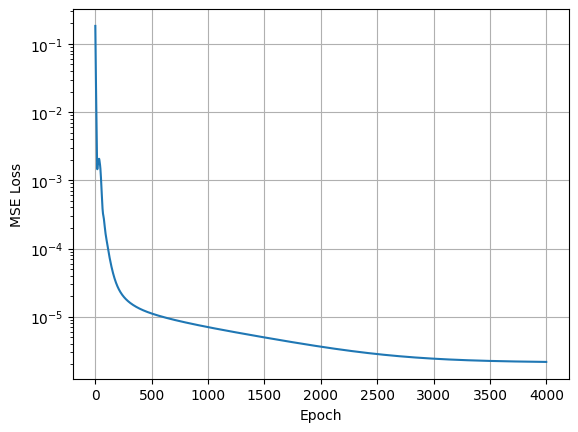

In [9]:
# Set up optimization
E_direct = torch.ones(elements.shape[0], requires_grad=True)
optimizer = torch.optim.Adam([E_direct], lr=0.1)
history = []

for epoch in tqdm(range(4000)):
    # Reset gradients
    optimizer.zero_grad()

    # Update material field
    sample.material = IsotropicElasticityPlaneStress(E=E_direct, nu=nu_centers)

    # Compute MSE loss between predicted and reference displacements
    u, _, _, _, _ = sample.solve()
    loss = torch.mean((u - u_ref) ** 2)

    # Make optimizer step
    loss.backward()
    optimizer.step()

    # Append training loss
    with torch.autograd.no_grad():
        history.append(float(loss.data))

# Plot history
plt.semilogy(history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()

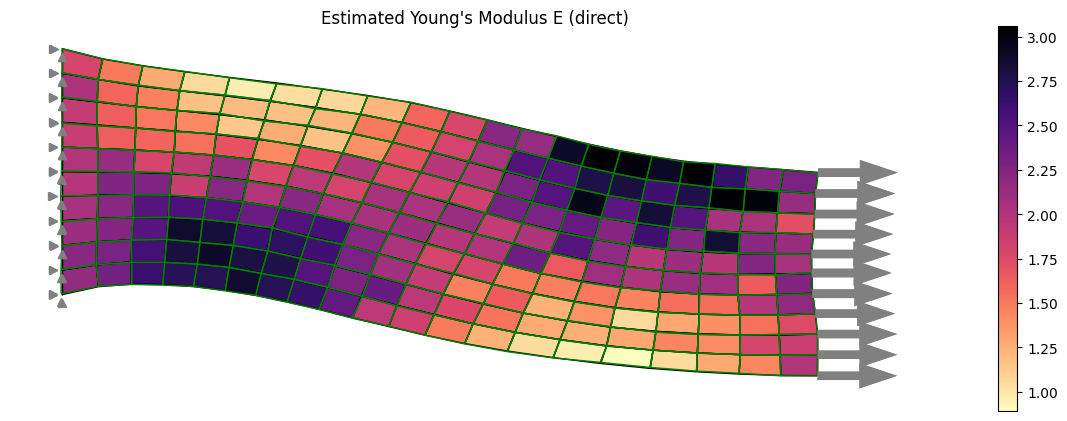

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot optimized
sample.plot(
    u,
    element_property=E_direct,
    title="Estimated Young's Modulus E (direct)",
    colorbar=True,
    cmap="magma_r",
    figsize=(15, 5),
    ax=ax,
)
# Plot reference
sample.plot(u=u_ref, color="green", ax=ax)

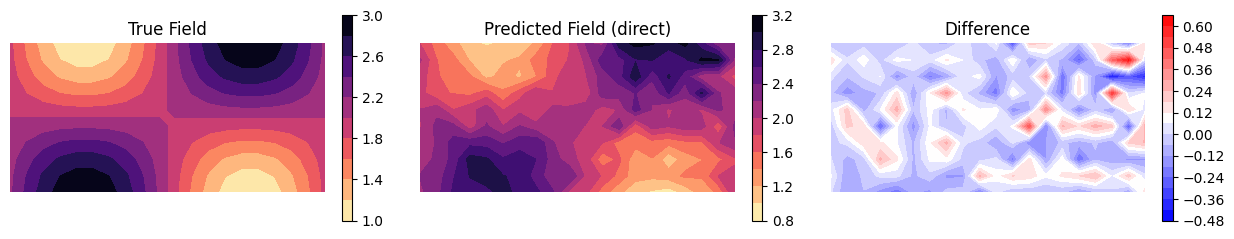

In [11]:
# Evaluate true field on grid
E_true = E(ecenters).reshape(X.shape)

# Predicted field
E_pred = E_direct.detach().reshape(X.shape)

# Evaluate difference
delta = E_pred - E_true

with torch.no_grad():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    c1 = ax[0].contourf(X, Y, E_true, levels=10, cmap="magma_r")
    ax[0].set_title("True Field")
    ax[0].set_aspect("equal")
    ax[0].set_axis_off()
    fig.colorbar(c1, ax=ax[0], fraction=0.03)
    c2 = ax[1].contourf(X, Y, E_pred, levels=10, cmap="magma_r")
    ax[1].set_title("Predicted Field (direct)")
    ax[1].set_aspect("equal")
    ax[1].set_axis_off()
    fig.colorbar(c2, ax=ax[1], fraction=0.03)
    c3 = ax[2].contourf(X, Y, delta, levels=20, cmap="bwr")
    ax[2].set_title("Difference")
    ax[2].set_aspect("equal")
    ax[2].set_axis_off()
    fig.colorbar(c3, ax=ax[2], fraction=0.03)
    plt.show()

With observation noise, the discrete approximation of the field becomes quite irregular, as each variable is independent of its neighbors.

## Solution of the inverse problem via a neural field

The previous attempt recovers the discrete distribution of the elastic modulus. However, it does not recover the continuous underlying function and is susceptible to noise. Therefore, we introduce a neural field as approximation to the continuous stiffness distribution, which is trained trough the FE solver with reference displacements.

The stiffness must be positive, in particular we know 
$$
E(x) > 1 \quad \forall x \in \Omega
$$ 
a priori in this task. Therefore, we enforce this physical property in the NN design with a ReLu output activation layer and addition of a constant in the output layer.



*Note:* This takes about two minutes to solve 8000 iterations.

In [12]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(2, 100)
        self.layer2 = torch.nn.Linear(100, 100)
        self.layer3 = torch.nn.Linear(100, 1)

    def forward(self, x):
        layer1_out = torch.tanh(self.layer1(x))
        layer2_out = torch.tanh(self.layer2(layer1_out))
        output = torch.relu(self.layer3(layer2_out))
        return output.squeeze() + 1.0


neural_field = Net()

100%|██████████| 8000/8000 [01:24<00:00, 95.11it/s] 


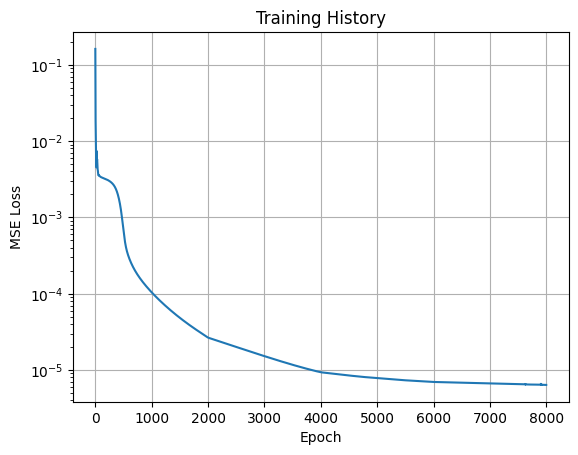

In [13]:
# Set up optimization
optimizer = torch.optim.Adam(neural_field.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2000, gamma=0.5)
history = []

for epoch in tqdm(range(8000)):
    # Reset gradients
    optimizer.zero_grad()

    # Update material field
    E_centers = neural_field(ecenters)
    sample.material = IsotropicElasticityPlaneStress(E=E_centers, nu=nu_centers)

    # Compute MSE loss between predicted and reference displacements
    u, _, _, _, _ = sample.solve()
    loss = torch.mean((u - u_ref) ** 2)

    # Make optimizer step
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Append training loss
    with torch.autograd.no_grad():
        history.append(float(loss.data))

plt.semilogy(history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training History")
plt.grid()
plt.show()

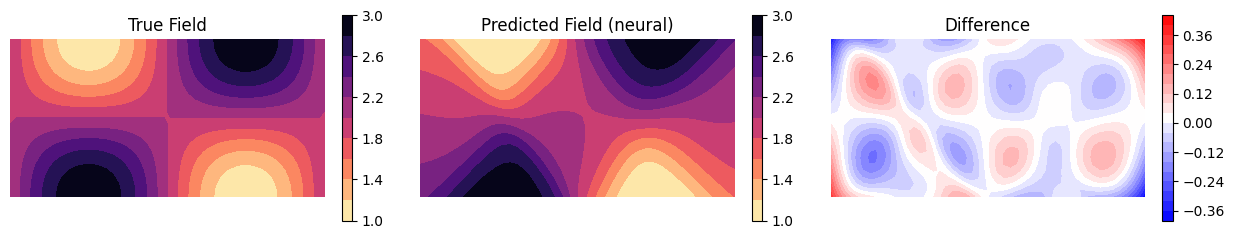

In [14]:
# Create grid for evaluation
x = torch.linspace(0, 2.0, 50)
y = torch.linspace(0, 1.0, 25)
X, Y = torch.meshgrid(x, y, indexing="ij")
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1)

# Evaluate neural field on grid
E_pred = neural_field(grid_points).reshape(X.shape)

# Evaluate true field on grid
E_true = E(grid_points).reshape(X.shape)

# Evaluate difference
delta = E_pred - E_true

with torch.no_grad():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    c1 = ax[0].contourf(X, Y, E_true, levels=10, cmap="magma_r")
    ax[0].set_title("True Field")
    ax[0].set_aspect("equal")
    ax[0].set_axis_off()
    fig.colorbar(c1, ax=ax[0], fraction=0.03)
    c2 = ax[1].contourf(X, Y, E_pred, levels=10, cmap="magma_r")
    ax[1].set_title("Predicted Field (neural)")
    ax[1].set_aspect("equal")
    ax[1].set_axis_off()
    fig.colorbar(c2, ax=ax[1], fraction=0.03)
    c3 = ax[2].contourf(X, Y, delta, levels=20, cmap="bwr")
    ax[2].set_title("Difference")
    ax[2].set_aspect("equal")
    ax[2].set_axis_off()
    fig.colorbar(c3, ax=ax[2], fraction=0.03)
    plt.show()

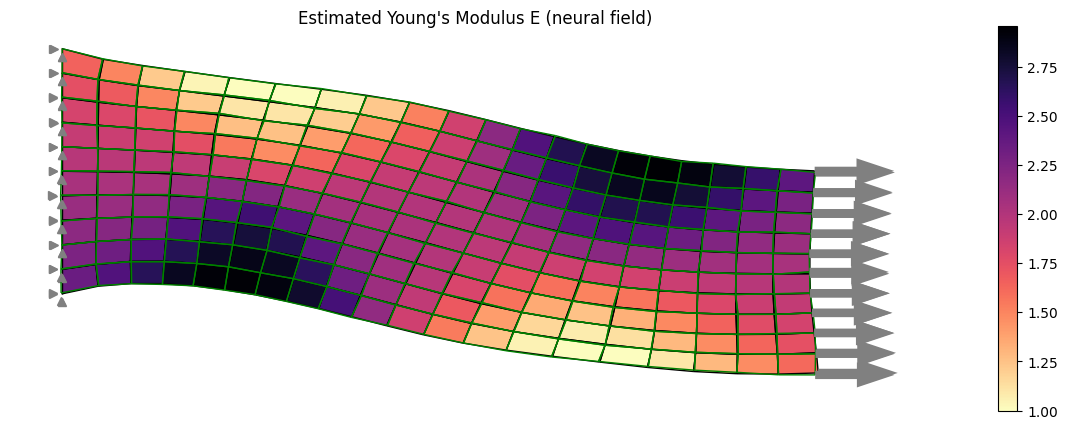

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

sample.plot(
    u,
    element_property=neural_field(ecenters),
    title="Estimated Young's Modulus E (neural field)",
    colorbar=True,
    cmap="magma_r",
    figsize=(15, 5),
    ax=ax,
)
sample.plot(u=u_ref, color="green", ax=ax)

Training the neural field takes more iterations in order to get to a comparable accuracy. However, the neural field regularizes the property field and gives a much smoother representation that is less susceptible to noise. 